In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/MyDrive/Colab Notebooks/가스공급량 수요예측 모델개발")

# method 2. local repository로 접근
# 따로 할 거 없음..

In [2]:
# import libary
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os, glob, sys
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./datasets/한국가스공사_시간별 공급량.csv", encoding = 'cp949', engine='python')

# test_csv 파일 전처리
test_csv = pd.read_csv("./datasets/test.csv", encoding = 'utf-8')

test_date = []
test_hour = []
test_class = []

for component in test_csv.values:
    string = component.item()
    test_date.append(string.split(" ")[0])
    test_hour.append(string.split(" ")[1])
    test_class.append(string.split(" ")[-1])

test_csv = pd.DataFrame({'연월일':test_date, "시간":test_hour, "구분":test_class})
sample_submission = pd.read_csv("./datasets/sample_submission.csv", encoding = "utf-8")

In [3]:
# rename column
train_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class", "공급량":"power"}, inplace = True)

In [4]:
# rename column
test_csv.rename(columns = {'연월일' : 'time', "시간":"hour", "구분":"class"}, inplace = True)

In [5]:
# 자료형 변환
from datetime import datetime

# time : str to datetime
try:
    train_csv["time"] = train_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
    test_csv["time"] = test_csv["time"].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))
except:
    print("data type of time not str or already converted")

# hour : str to int

try:
    test_csv["hour"] = test_csv["hour"].apply(lambda x : int(x))
except:
    print("data type of hour not str or already converted")

In [6]:
# time - hour => timestamp with yyyy-mm-dd-hh
import datetime

def df_time_convert(df):
    df_copy = df.copy(...)
    timestamp_list = []
    for idx in range(len(df)):
        timestamp_list.append(df_copy.time.iloc[idx] + datetime.timedelta(hours = df_copy.hour.iloc[idx].item()))
    df_copy["time"] = timestamp_list
    return df_copy

# class에 따른 데이터프레임 분류
def df_class_split(df, cls = "A"):
    df_copy = df.copy(...)
    df_copy = df_copy[df_copy["class"] == cls]
    return df_copy

# class to idx
def class_to_idx(x):
    dic = {'A':0,"B":1,"C":2,"D":3,'E':4,'G':5,"H":6}
    if type(x) == str:
        try:
            return_value = int(dic[x])
        except:
            return_value = 0
            print("didn't find class {}".format(x))

    else:
        return_value = 0
    
    return return_value

# convert original scale to log scale
def convert2log(x):
    eps = 1e-6
    if abs(x) < eps:
        return NaN
    else:
        return np.log1p(x)
    
def convert2origin(x):
    return np.exp(x) - 1

In [7]:
import matplotlib.pyplot as plt
from datetime import timedelta

def plot_time_series_data(df, xl = None, xr = None, figsize = (16,8), col = "power", label = "power", c = "b", fig_num = 1):

    x_axis = df.time
    y_axis = df[col]

    if xl is None and xr is None:
        pass
    elif xl is not None and xr is None:
        x_axis = x_axis[xl:]
        y_axis = y_axis[xl:]
    elif xl is None and xr is not None:
        x_axis = x_axis[:xr]
        y_axis = y_axis[:xr]
    else:
        x_axis = x_axis[xl:xr]
        y_axis = y_axis[xl:xr]

    plt.figure(fig_num, figsize = figsize)
    plt.plot(x_axis, y_axis, label = label, c = c)
    plt.xlabel("time")
    plt.ylabel("power")
    plt.legend()
    plt.show()

In [8]:
# External Data(weather)
import glob2
import datetime

path_list_external_weather = glob2.glob("./dataset_external_weather/*")
print(path_list_external_weather)

df_weather = None
for idx, path in enumerate(path_list_external_weather):

    if idx == 0:
        df_weather = pd.read_csv(path, encoding = "cp949")
    else:
        df_temp = pd.read_csv(path, encoding = "cp949")
        df_weather = pd.concat([df_weather, df_temp], axis = 0)


# column name change
df_weather.rename(columns = {"일시": "date_time","기온(°C)" : "temperature", "습도(%)":"humidity", "증기압(hPa)" : "vapor", "현지기압(hPa)":"pressure", "풍속(m/s)":"wind_speed"}, inplace = True)

df_weather["date_time"] = df_weather["date_time"].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%d %H:%M" ))

# 결측치 보완
df_weather["temperature"] = df_weather["temperature"].interpolate(method = "values")
df_weather["humidity"] = df_weather["humidity"].interpolate(method = "values")
df_weather["vapor"] = df_weather["vapor"].interpolate(method = "values")
df_weather["wind_speed"] = df_weather["wind_speed"].interpolate(method = "values")
df_weather["pressure"] = df_weather["pressure"].interpolate(method = "values")

# merge
df = train_csv.copy()
df = df_time_convert(df)
df["class"] = df["class"].apply(lambda x : class_to_idx(x))

df_merge = pd.merge(left = df, right = df_weather[["date_time", "temperature", "humidity", "vapor", "pressure", "wind_speed"]], how = 'outer', left_on = "time", right_on = "date_time")
df_merge = df_merge.drop(columns = ['date_time'], axis = 1)

['./dataset_external_weather/OBS_ASOS_TIM_20211017003024.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017003117.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004006.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004047.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004154.csv', './dataset_external_weather/OBS_ASOS_TIM_20211017004224.csv']


In [9]:
df_merge = df_merge.dropna()

In [10]:
# anomality annhiliation
# 우선 class별로 분포가 다르므로, class에 따라 묶어서 anomality annhiliation을 진행한다
class_list = np.unique(train_csv["class"].values).tolist()
df_list = [df_class_split(df_merge, cls = i).sort_values(by = ["time"]) for i in range(len(class_list))]

# 데이터 구분
# df_list : class별로 나눈 데이터
# df_merge : 외부데이터까지 하나로 합친 데이터

# range and length analysis
idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

class : A, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52584, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [11]:
# 이상치 제거
def remove_outlier(df_input, column):
    df = df_input.copy(...)
    df_removed_column_outlier = df[column]
    quan_25 = np.percentile(df_removed_column_outlier.values, 25)
    quan_75 = np.percentile(df_removed_column_outlier.values, 75)

    iqr = quan_75 - quan_25
    iqr = iqr * 1.5

    lowest = quan_25 - iqr
    highest = quan_75 + iqr

    outlier_index = df_removed_column_outlier[(df_removed_column_outlier < lowest) | (df_removed_column_outlier > highest)].index
    
    if len(outlier_index) > 0:
        print("# outlier detected")
        df.drop(outlier_index, axis = 0, inplace = True)
    else:
        print("# outlier not detected")
        pass

    return df

df_list_new = []
for df in df_list:
    df = remove_outlier(df, "power")
    df_list_new.append(df)

df_list = df_list_new

idx_to_class = ['A', 'B','C', 'D', "E", 'G', 'H']
for idx, df in enumerate(df_list):
    print("class : {}, length : {}, start time : {}, end time : {}".format(
        idx_to_class[idx],
        len(df),
        df['time'].iloc[0],
        df['time'].iloc[-1]
    ))

# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
# outlier detected
class : A, length : 52231, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : B, length : 52300, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : C, length : 52308, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : D, length : 52439, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : E, length : 52332, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : G, length : 52214, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00
class : H, length : 52352, start time : 2013-01-01 01:00:00, end time : 2019-01-01 00:00:00


In [12]:
# 0인 이상치도 제거...
df_list_new = []
for df in df_list:
    index_list = df["power"].values >= 10
    df = df.iloc[index_list]
    df_list_new.append(df)

df_list = df_list_new

In [64]:
# supervised learning 적용
def series2supervised(data, cols = ["power"], n_in = 1, dropnan = True): 
    data_copy = data.copy(...)
    d_cols, names = [], []

    for col in cols: 
        for i in range(n_in, 0, -24):
            d_shift = data_copy[col].shift(i).values
            d_cols.append(d_shift)
            name = '{}(t-{})'.format(col, i)
            names.append(name)

    for name, d_col in zip(names, d_cols):
        data_copy[name] = d_col
        
    if dropnan:
        data_copy.dropna(inplace=True)
    return data_copy

df_list_new = []
for df in df_list:
    # convert power scale to log scale
    df["power"] = df["power"].apply(lambda x : convert2log(x))
    # supervised data
    df_supervised = series2supervised(df, cols = ["power"], n_in = 24 * 30)
    df_list_new.append(df_supervised)

df_list = df_list_new

In [65]:
# 최종적으로 쓸 dataframe
# df_list를 모두 합친 데이터프레임
df = None

for df_class in df_list:
    if df is None:
        df = df_class
    else:
        df = pd.concat([df, df_class], axis = 0)

display(df)

,time,hour,class,power,temperature,humidity,vapor,pressure,wind_speed,power(t-720),power(t-696),power(t-672),power(t-648),power(t-624),power(t-600),power(t-576),power(t-552),power(t-528),power(t-504),power(t-480),power(t-456),power(t-432),power(t-408),power(t-384),power(t-360),power(t-336),power(t-312),power(t-288),power(t-264),power(t-240),power(t-216),power(t-192),power(t-168),power(t-144),power(t-120),power(t-96),power(t-72),power(t-48),power(t-24)
10780,2013-03-06 05:00:00,5.0,0.0,7.469527,1.0,73.0,4.8,1011.6,3.2,7.680413,7.988877,8.022501,8.002949,8.078063,7.881449,7.694164,7.751338,7.720501,7.626150,7.537200,7.428510,7.550616,7.418997,7.314010,7.477062,7.593193,7.626048,7.570332,7.579957,7.466704,7.492605,7.417187,7.366825,7.390809,7.253307,7.441715,7.407668,7.447882,7.505748
10787,2013-03-06 06:00:00,6.0,0.0,7.532902,1.1,68.0,4.5,1011.7,2.2,7.777076,8.007860,8.034528,8.014220,8.004508,7.794853,7.578621,7.663863,7.611071,7.553979,7.622289,7.530841,7.629175,7.491401,7.438257,7.576475,7.690107,7.714667,7.646904,7.642893,7.500375,7.593971,7.481426,7.442498,7.472897,7.254320,7.476292,7.440058,7.534575,7.569185
10794,2013-03-06 07:00:00,7.0,0.0,7.732068,1.6,62.0,4.2,1011.8,3.1,7.820135,7.935940,7.967525,7.946737,7.958194,7.740654,7.509178,7.604883,7.551263,7.596799,7.695063,7.606722,7.696042,7.520343,7.539925,7.674785,7.776254,7.837100,7.765495,7.673339,7.526671,7.739565,7.642306,7.606881,7.631036,7.302087,7.515254,7.459146,7.743731,7.760986
10801,2013-03-06 08:00:00,8.0,0.0,7.938805,2.0,58.0,4.1,1012.4,2.4,7.832951,7.870414,7.936300,7.902402,7.929890,7.755459,7.555822,7.635953,7.600619,7.686622,7.832094,7.752202,7.725980,7.537473,7.704589,7.793267,7.888194,8.024554,7.954016,7.806026,7.635919,7.949879,7.863664,7.824379,7.842568,7.465619,7.673287,7.581068,7.953172,7.973189
10808,2013-03-06 09:00:00,9.0,0.0,7.876961,3.3,49.0,3.8,1012.7,3.0,7.776982,7.783391,7.872413,7.823035,7.879140,7.813773,7.632107,7.705555,7.688009,7.778410,8.037257,7.962859,7.860454,7.641304,7.908485,7.993607,8.081616,8.039305,7.987441,7.875068,7.707509,7.968733,7.887371,7.849680,7.855375,7.571874,7.730646,7.660748,7.925088,7.936866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368059,2018-12-31 20:00:00,20.0,6.0,6.525078,-3.7,39.0,1.8,1024.9,0.8,5.982734,5.984344,5.850485,5.822643,6.124436,6.079240,6.349055,6.473846,6.469301,6.389183,6.323966,6.327847,6.341720,6.387660,6.396456,6.367235,6.242282,6.205618,6.145537,6.161007,6.113060,6.083645,6.113043,6.303750,6.286035,6.252751,6.494941,6.401023,6.551754,6.520863
368066,2018-12-31 21:00:00,21.0,6.0,6.508711,-4.6,44.0,1.9,1024.8,1.1,5.835796,5.808860,5.736175,5.761337,6.015169,5.933661,6.242393,6.370047,6.338534,6.264154,6.218188,6.205160,6.240276,6.272817,6.265219,6.209923,6.129094,6.065363,5.999351,6.018257,5.942038,5.939855,5.932802,6.171772,6.119150,6.144778,6.388642,6.518169,6.544910,6.509725
368073,2018-12-31 22:00:00,22.0,6.0,6.490634,-5.4,46.0,1.9,1024.4,1.3,5.768049,5.774797,5.728638,5.728371,5.937222,5.860983,6.193650,6.283774,6.282880,6.206524,6.164909,6.142712,6.179298,6.204370,6.179122,6.172154,6.063427,6.011784,5.912681,5.920959,5.882026,5.848933,5.898845,6.108478,6.046213,6.114834,6.321351,6.610956,6.529797,6.476431
368080,2018-12-31 23:00:00,23.0,6.0,6.416655,-5.2,47.0,2.0,1024.6,1.6,5.716784,5.747369,5.656534,5.679394,5.869862,5.822442,6.159480,6.230409,6.232841,6.153743,6.121953,6.102601,6.105509,6.157724,6.121101,6.134356,6.003704,5.963883,5.844506,5.848108,5.854582,5.799541,5.862790,6.062435,5.994510,6.081276,6.285150,6.549920,6.471330,6.410545


In [66]:
# year / month / day -> sinusoidal value
day = 24 * 60 * 60
month = (30.0) * day
year = (365.2425)*day

df["month_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df["month_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df["year_cos"] = np.cos(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df["year_sin"] = np.sin(df.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df["day_cos"] = np.cos(df.hour.values * (2 * np.pi / 24))
df["day_sin"] = np.sin(df.hour.values * (2 * np.pi / 24))

output.clear()

In [67]:
# categorical variable로 전환
df["class"] = df["class"].astype("category")

In [70]:
power_cols = [name for name in list(df.keys()) if name.split("(")[0] == "power"]

Text(0, 0.5, 'correlation')

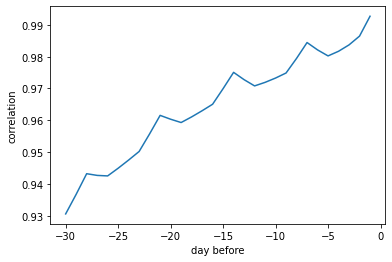

In [77]:
time_idx_list = []
corr_list = []

for col in power_cols:

    if col == "power":
        continue
    
    time_idx = int(col.split("-")[1].split(")")[0])
    time_idx_list.append(-time_idx // 24)
    
    corr = df[["power", col]].corr()["power"][1]
    corr_list.append(corr)

plt.plot(time_idx_list, corr_list)
plt.xlabel("day before")
plt.ylabel("correlation")

# 7, 14, 21, 28, 
# lgbm / catboost : timestamp(7,14,21,28) experiment
# exp - model.ipynb(lgbm / catboost) => 범주형 변수에 대한 추가적인 옵션 찾아보기!(원 핫 인코딩 : 디폴트, pandas 데이터 유형)
# df에서 카테고리컬한 자료형으로 지정(lgbm 에서도 범주형 변수에 대한 옵션 찾아보기)
# tree model 칼럼 많으면 됨..???? 

In [78]:
# train - test split process
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size = 0.3, random_state = 42)
df_valid, df_test = train_test_split(df_valid, test_size = 0.4, random_state = 42)

In [79]:
def calc_nmae(y_test, y_pred):
    score = np.mean((np.abs((y_test - y_pred)/y_test)))
    return score

In [ ]:
# 주어진 데이터 프레임 구조
display(df)

In [83]:
# lgbm
import lightgbm as lgb
power_cols = [name for name in list(df.keys()) if name.split("(")[0] == "power"]
power_cols.remove("power")

other_cols = ["year_cos","month_cos","day_cos", "class"]
x_cols = other_cols + power_cols

y_cols = ["power"]
cols = x_cols + y_cols

x_train, y_train = df_train[x_cols], df_train[y_cols]
x_valid, y_valid = df_valid[x_cols], df_valid[y_cols]
x_test, y_test = df_test[x_cols], df_test[y_cols]

train_data = lgb.Dataset(x_train, y_train)
valid_data = lgb.Dataset(x_valid, y_valid)
test_data = lgb.Dataset(x_test, y_test)

# model architecture
esr = 400 
nbr = 50

params = {
    "boosting_type":"dart", # gbdt, rf, dart, goss
    "num_leaves":64,
    "max_depth":-1,
    "learning_rate":0.3,
    "objective":"regression",
    "n_estimators":1024,
    "subsample_for_bin":200000,
    "min_split_gain":0.7,
    "min_child_weight":1e-3,
    "min_child_samples":20,
    "subsample":1.0,
    "subsample_freq":0,
    "colsample_bytree":1.0,
    "reg_alpha":0.01,
    "reg_lambda":0.01,
    "n_jobs":-1,
    "metric":"mse",
    'num_threads': 8,
}

# custom metric(nmae)
from sklearn.metrics import mean_squared_error

def custom_metric(y_pred, dataset, isLogScale = True):
    y_true = dataset.get_label().reshape(-1,)
    y_pred = y_pred.reshape(-1,)

    if isLogScale:
        y_true = np.exp(y_true) + 1
        y_pred = np.exp(y_pred) + 1

    eps = 1e-3
    score = np.mean((np.abs(y_true - y_pred)) / (y_true + eps))
    return 'custom_metric score', score, False

model = lgb.train(params, train_data, valid_sets = valid_data, num_boost_round = nbr, early_stopping_rounds = esr, feval = custom_metric)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[1]	valid_0's l2: 0.59699	valid_0's custom_metric score: 0.803389
[2]	valid_0's l2: 0.299717	valid_0's custom_metric score: 0.512442
[3]	valid_0's l2: 0.153622	valid_0's custom_metric score: 0.346363
[4]	valid_0's l2: 0.0817274	valid_0's custom_metric score: 0.243239
[5]	valid_0's l2: 0.0462285	valid_0's custom_metric score: 0.177231
[6]	valid_0's l2: 0.0286001	valid_0's custom_metric score: 0.134937
[7]	valid_0's l2: 0.0197829	valid_0's custom_metric score: 0.108731
[8]	valid_0's l2: 0.0335061	valid_0's custom_metric score: 0.147946
[9]	valid_0's l2: 0.0220998	valid_0's custom_metric score: 0.116292
[10]	valid_0's l2: 0.0163876	valid_0's custom_metric score: 0.0970716
[11]	valid_0's l2: 0.013462	valid_0's custom_metric score: 0.0857547
[12]	valid_0's l2: 0.0157495	valid_0's custom_metric score: 0.0948621
[13]	valid_0's l2: 0.0131059	valid_0's custom_metric score: 0.0843204
[14]	valid_0's l2: 0.0116854	valid_0's custom_metric score: 0.0782379
[15]	valid_0's l2: 0.0109418	valid_0's cust

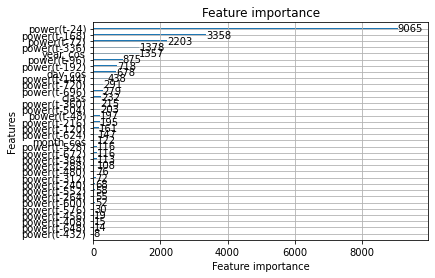

In [84]:
# plot importance
lgb.plot_importance(model)

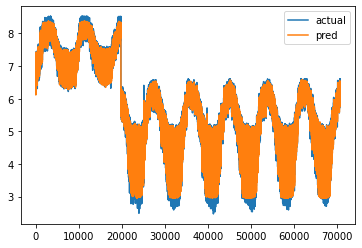

In [90]:
test_size = int(len(df) * 0.2)

eval_set = df.iloc[-test_size:]
x_eval = eval_set[x_cols]
y_eval = eval_set[y_cols]

y_eval_pred = model.predict(x_eval)
y_eval = y_eval.reset_index().power

plt.plot(y_eval, label = "actual")
plt.plot(y_eval_pred, label = "pred")
plt.legend()
plt.show()

In [93]:
# submission
idx_to_class = ['A','B','C','D',"E",'G','H']

df_submission = test_csv.copy()
df_submission = df_time_convert(df_submission)

df_submission['class'] = df_submission['class'].apply(lambda x : class_to_idx(x))
df_submission['class'] = df_submission['class'].astype("category")

df_submission["month_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))
df_submission["month_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / month))

df_submission["year_cos"] = np.cos(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))
df_submission["year_sin"] = np.sin(df_submission.time.map(datetime.datetime.timestamp) * (2 * np.pi / year))

df_submission["day_cos"] = np.cos(df_submission.hour.values * (2 * np.pi / 24))
df_submission["day_sin"] = np.sin(df_submission.hour.values * (2 * np.pi / 24))

output.clear()

In [99]:
df[df["class"] == 0].iloc[-1][power_cols]

power(t-720)    7.43359
power(t-696)    7.32584
power(t-672)    7.55036
power(t-648)    7.48339
power(t-624)    7.80906
power(t-600)    7.74536
power(t-576)    7.96469
power(t-552)    7.87669
power(t-528)    7.85415
power(t-504)    8.04121
power(t-480)     7.9957
power(t-456)    8.00388
power(t-432)    7.99703
power(t-408)    8.08193
power(t-384)    7.93486
power(t-360)    7.72252
power(t-336)    7.95077
power(t-312)    7.96523
power(t-288)    7.87212
power(t-264)    7.88791
power(t-240)    7.90848
power(t-216)    7.59874
power(t-192)    7.48737
power(t-168)     7.9559
power(t-144)    7.71274
power(t-120)    7.93957
power(t-96)     8.07947
power(t-72)     7.95049
power(t-48)     8.01974
power(t-24)     7.99526
Name: 368081, dtype: object

In [100]:
df_submission[df_submission["class"] == 0]

,time,hour,class,month_cos,month_sin,year_cos,year_sin,day_cos,day_sin
0,2019-01-01 01:00:00,1,0,-0.909961,-0.414693,0.999996,0.002738,0.965926,2.588190e-01
1,2019-01-01 02:00:00,2,0,-0.906308,-0.422618,0.999994,0.003455,0.866025,5.000000e-01
2,2019-01-01 03:00:00,3,0,-0.902585,-0.430511,0.999991,0.004172,0.707107,7.071068e-01
3,2019-01-01 04:00:00,4,0,-0.898794,-0.438371,0.999988,0.004888,0.500000,8.660254e-01
4,2019-01-01 05:00:00,5,0,-0.894934,-0.446198,0.999984,0.005605,0.258819,9.659258e-01
...,...,...,...,...,...,...,...,...,...
2155,2019-03-31 20:00:00,20,0,-0.927184,-0.374607,0.023390,0.999726,0.500000,-8.660254e-01
2156,2019-03-31 21:00:00,21,0,-0.923880,-0.382683,0.022673,0.999743,0.707107,-7.071068e-01
2157,2019-03-31 22:00:00,22,0,-0.920505,-0.390731,0.021957,0.999759,0.866025,-5.000000e-01
2158,2019-03-31 23:00:00,23,0,-0.917060,-0.398749,0.021240,0.999774,0.965926,-2.588190e-01


In [106]:
model.predict(df.iloc[0][x_cols].values.reshape(1,-1))

array([7.47314865])

In [129]:
df.iloc[-1][power_cols].values.reshape(1,-1)

array([[5.613233940203533, 5.6767127055334115, 5.555900991175784,
        5.566969513093012, 5.806862391724887, 5.731916313899973,
        6.107492710543092, 6.1900018321038734, 6.175646871599421,
        6.073843753809739, 6.0493465879556325, 6.018585915199521,
        6.05469283526508, 6.084982212226443, 6.05707202795449,
        6.098855999017902, 5.903392607921031, 5.8764239973968495,
        5.748261773079804, 5.732803915716604, 5.780215598690837,
        5.70598671020976, 5.836957553808618, 5.968106356280727,
        5.96133518212647, 6.007502744880717, 6.251647588282771,
        6.456543570362197, 6.401582148896803, 6.344180916217838]],
      dtype=object)

In [130]:
def inference_lgbm(model, df_submission, df):
    # df_submission : 예측하고자 하는 데이터 프레임
    # df : 기존에 가지고 있던 데이터(훈련 + 검증 데이터 전부)

    pred_list = []

    for class_idx in range(len(class_list)):
        inputs_power = df[df["class"] == class_idx].iloc[-1][power_cols].values.reshape(1,-1)


        df_submission_class = df_submission[df_submission["class"] == class_idx]

        pred_list_per_class = []

        for idx in range(len(df_submission_class)):
            x1 = df_submission_class[other_cols].iloc[idx].values.reshape(1,-1)
            x2 = inputs_power 

            inputs = np.concatenate((x1, x2), axis = 1)

            # model prediction
            pred = model.predict(inputs)
            pred_list_per_class.append(np.array([convert2origin(pred)]))

            # input update
            inputs_power = np.concatenate((inputs_power, pred.reshape(1,-1)), axis = 1)[:,1:]


        pred_list.extend(pred_list_per_class)

    return pred_list

predictions = inference_lgbm(model, df_submission, df)
predictions = np.array(predictions).reshape(-1,1)

sample_submission["공급량"] = predictions

# submission 
from google.colab import files

sample_submission.to_csv("submission_lgbm_supervised_1127.csv", index = False)
files.download("submission_lgbm_supervised_1127.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>